In [10]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import folium
import os
import numpy as np
import matplotlib.colors as mcolors
%matplotlib inline

In [11]:
# Load the shapefiles
gdf1 = gpd.read_file(glob.glob("/mnt/gis-nfs/users/abreunig/superparcels/mitre/*dt30*.shp")[0])
gdf2 = gpd.read_file(glob.glob("/mnt/gis-nfs/users/abreunig/superparcels/mitre/*dt50*.shp")[0])
gdf3 = gpd.read_file(glob.glob("/mnt/gis-nfs/users/abreunig/superparcels/mitre/*dt75*.shp")[0])
gdf4 = gpd.read_file(glob.glob("/mnt/gis-nfs/users/abreunig/superparcels/mitre/*dt100*.shp")[0])
gdf5 = gpd.read_file(glob.glob("/mnt/gis-nfs/users/abreunig/superparcels/mitre/*dt150*.shp")[0])
gdf6 = gpd.read_file(glob.glob("/mnt/gis-nfs/users/abreunig/superparcels/mitre/*dt200*.shp")[0])
ref_candidates = gpd.read_file(glob.glob("/mnt/Ddrive/projects/superparcels/inputs/55107/*.shp")[0])

/home/abreunig_solutions_corelogic_com/miniforge3/envs/sp_dev/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: /mnt/gis-nfs/users/abreunig/superparcels/mitre/spfixed_55107-ss3-dt100.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Spatial Join each distance threshold on itself using the OVERLAP predicate. The OVERLAP is TRUE if two polygons share some area but do not CONTAIN one another. 

In [12]:
sjoin = gpd.sjoin(gdf6, gdf6, how='left', predicate='overlaps')[['sp_id_left', 'owner_left', 'owner_right', 'geometry']]

Remove instances where the geometry overlaps itself or where the spatial join did not hit anything

In [13]:
mismatch = sjoin[sjoin['owner_left'] != sjoin['owner_right']]
mismatch = mismatch[mismatch['owner_right'].notnull()]
mismatch.head(2)


,sp_id_left,owner_left,owner_right,geometry
0,ADAMS DAWN M_0_0,ADAMS DAWN M,TRI-STATE HOLDINGS LLC,"POLYGON ((645738.217 5035624.138, 645748.499 5..."
1,ADAMS TROY G_0_0,ADAMS TROY G,REDISKE STEVEN M,"POLYGON ((633574.147 5047326.802, 633171.605 5..."


Join mismatches back to original geodataframe to obtain the *other* geometry that overlapped. There now should be the key geometry (geometry_x) and the *other* geometry (geometry_y)

In [14]:
sjoin_right = pd.merge(mismatch, gdf6[['owner', 'geometry']], left_on='owner_right', right_on='owner', how='inner')
sjoin_right.head(2)

,sp_id_left,owner_left,owner_right,geometry_x,owner,geometry_y
0,ADAMS DAWN M_0_0,ADAMS DAWN M,TRI-STATE HOLDINGS LLC,"POLYGON ((645738.217 5035624.138, 645748.499 5...",TRI-STATE HOLDINGS LLC,"POLYGON ((644500.052 5034677.576, 644478.84 50..."
1,ADAMS TROY G_0_0,ADAMS TROY G,REDISKE STEVEN M,"POLYGON ((633574.147 5047326.802, 633171.605 5...",REDISKE STEVEN M,"POLYGON ((633995.542 5046394.943, 634017.72 50..."


Create a new geometry based on the intersection of the two geometries. This geoemtry is the overlap. Calcualte the area or size.

In [15]:
sjoin_right['diff_area'] = sjoin_right.apply(lambda x: x['geometry_x'].intersection(x['geometry_y']).area, axis=1)
sjoin_right.head()


,sp_id_left,owner_left,owner_right,geometry_x,owner,geometry_y,diff_area
0,ADAMS DAWN M_0_0,ADAMS DAWN M,TRI-STATE HOLDINGS LLC,"POLYGON ((645738.217 5035624.138, 645748.499 5...",TRI-STATE HOLDINGS LLC,"POLYGON ((644500.052 5034677.576, 644478.84 50...",1.527783e-06
1,ADAMS TROY G_0_0,ADAMS TROY G,REDISKE STEVEN M,"POLYGON ((633574.147 5047326.802, 633171.605 5...",REDISKE STEVEN M,"POLYGON ((633995.542 5046394.943, 634017.72 50...",1.100238e-07
2,ADERHOLD CRAIG_0_0,ADERHOLD CRAIG,EPPLEY GORDON H,"POLYGON ((615420.898 5024433.369, 615251.507 5...",EPPLEY GORDON H,"POLYGON ((614619.993 5024859.816, 614619.993 5...",2.543494e-07
3,ADERHOLD CRAIG_0_0,ADERHOLD CRAIG,GRONSKI STEVEN M,"POLYGON ((615420.898 5024433.369, 615251.507 5...",GRONSKI STEVEN M,"POLYGON ((615405.887 5026295.879, 615409.068 5...",0.000000e+00
4,ADKINS CLAIRE A_0_0,ADKINS CLAIRE A,MINTA MARK,"POLYGON ((654692.035 5045046.481, 654677.645 5...",MINTA MARK,"POLYGON ((655691.334 5045460.477, 655478.497 5...",6.443028e-06


Because the overlap will be TRUE if any slight deviation in coordinates, we need to remove the insignificant overlap geometries  -- inother words any area less than ~ 1 meter.

In [16]:
overlaps = sjoin_right[sjoin_right['diff_area'] > 1]

Now that we have our final overlap dataframe, we can extract the unique intersections based on our key owner field (_left) and how many *other* owner fields by using a groupby function.

In [47]:

gb = overlaps.groupby('owner_left')['owner_right'].nunique()
gb1 = gb.copy()
gb2 = gb.copy()

Results

In [49]:
data_dict = {
            f'{1}_overlaps': gb.sum(),
            f'{1}_sp_count': len(gdf6),
            f'{1}_pct_overlap': gb.sum() / len(gdf6) * 100,
            f'{1}_avg_overlap': gb.mean()
        }

df1 = pd.DataFrame(data_dict, index=[0])
df1.index = ['55107']
df1

,1_overlaps,1_sp_count,1_pct_overlap,1_avg_overlap
55107,820,2513,32.630322,1.550095


In [50]:
data_dict = {
            f'{2}_overlaps': gb2.sum(),
            f'{2}_sp_count': len(gdf6),
            f'{2}_pct_overlap': gb2.sum() / len(gdf6) * 100,
            f'{2}_avg_overlap': gb2.mean()
        }

df2 = pd.DataFrame(data_dict, index=[0])
df2.index = ['55107']
df2

,2_overlaps,2_sp_count,2_pct_overlap,2_avg_overlap
55107,820,2513,32.630322,1.550095


In [51]:
pd.concat([df1, df2], axis=1)

,1_overlaps,1_sp_count,1_pct_overlap,1_avg_overlap,2_overlaps,2_sp_count,2_pct_overlap,2_avg_overlap
55107,820,2513,32.630322,1.550095,820,2513,32.630322,1.550095


In [ ]:
total_number_of_intersects = gb.sum()
avg_intersects = gb.mean()
total_superparcels = len(gdf6)
percent_intersects = total_number_of_intersects / total_superparcels * 100
print(f'Total number of intersects: {total_number_of_intersects}')
print(f'Total number of superparcels: {total_superparcels}')
print(f'Percent intersects: {percent_intersects:.2f}%')
print(f'Average number of intersects: {avg_intersects:.2f}')

Total number of intersects: 820
Total number of superparcels: 2513
Percent intersects: 32.63%
Average number of intersects: 1.55


In [54]:
df = pd.read_csv('/mnt/Ddrive/projects/superparcels/outputs/dt_overlap_analysis.csv', index_col=0)
df

,30_overlaps,30_sp_count,30_pct_overlap,30_avg_overlap,50_overlaps,50_sp_count,50_pct_overlap,50_avg_overlap,75_overlaps,75_sp_count,...,100_pct_overlap,100_avg_overlap,150_overlaps,150_sp_count,150_pct_overlap,150_avg_overlap,200_overlaps,200_sp_count,200_pct_overlap,200_avg_overlap
8031,291,1721,16.908774,1.830189,831,2041,40.715336,2.216000,526,1840,...,32.120582,2.094915,831,2041,40.715336,2.216000,1037,2076,49.951830,2.362187
35051,8,287,2.787456,1.142857,48,340,14.117647,1.230769,34,339,...,14.117647,1.230769,68,339,20.058997,1.387755,119,355,33.521127,1.487500
16001,596,4142,14.389184,1.482587,882,3941,22.380107,1.618349,1251,3888,...,39.068666,1.804374,1941,3790,51.213720,1.917984,2326,3812,61.017838,2.052957
6037,3196,25176,12.694630,1.755080,10954,27715,39.523724,2.168250,6751,26115,...,31.128536,2.034077,10954,27715,39.523724,2.168250,12945,28543,45.352626,2.245447
41013,50,576,8.680556,1.219512,72,577,12.478336,1.263158,86,572,...,18.057922,1.376623,157,586,26.791809,1.539216,244,612,39.869281,1.768116
6091,40,261,15.325670,1.600000,66,241,27.385892,1.609756,72,299,...,39.837398,1.884615,113,273,41.391941,1.948276,142,260,54.615385,2.218750
6075,118,1004,11.752988,1.903226,421,1419,29.668781,2.215789,303,1241,...,24.415794,2.133803,421,1419,29.668781,2.215789,598,1574,37.992376,2.471074
55107,179,2466,7.258719,1.287770,325,2492,13.041734,1.394850,392,2488,...,18.996416,1.423881,622,2511,24.771008,1.506053,820,2513,32.630322,1.550095
48113,1151,7687,14.973332,1.630312,4067,9054,44.919373,2.094233,2586,8326,...,36.501105,1.983565,4067,9054,44.919373,2.094233,5083,9485,53.589879,2.234286
20097,8,286,2.797203,1.142857,86,333,25.825826,1.791667,34,316,...,12.422360,1.250000,86,333,25.825826,1.791667,40,322,12.422360,1.250000


In [55]:
df = pd.read_csv('/mnt/Ddrive/projects/superparcels/outputs/owner_count_analysis.csv', index_col=0)
df

,30,50,75,100,150,200
8031,1034,1201,1130,1147,1201,1241
35051,206,242,235,242,254,266
16001,2323,2416,2506,2561,2644,2684
6037,18018,19891,19021,19354,19891,20306
41013,369,378,385,391,397,403
6091,104,109,109,111,113,116
6075,657,804,756,756,804,844
55107,2038,2061,2072,2084,2096,2109
48113,5356,6243,5847,5986,6243,6404
20097,210,236,225,230,236,230


In [56]:
def zfill(s, width):
    return s.zfill(width)

# length of an integer


indexes = df.index
idx_list = []
for i in indexes:
    if len(str(i)) == 4:
        i = zfill(str(i), 5)
    idx_list.append(i)
    

In [57]:
# convert all elements to str
idx_list = [str(i) for i in idx_list]
df.index = idx_list

In [58]:
df.columns

Index(['30', '50', '75', '100', '150', '200'], dtype='object')

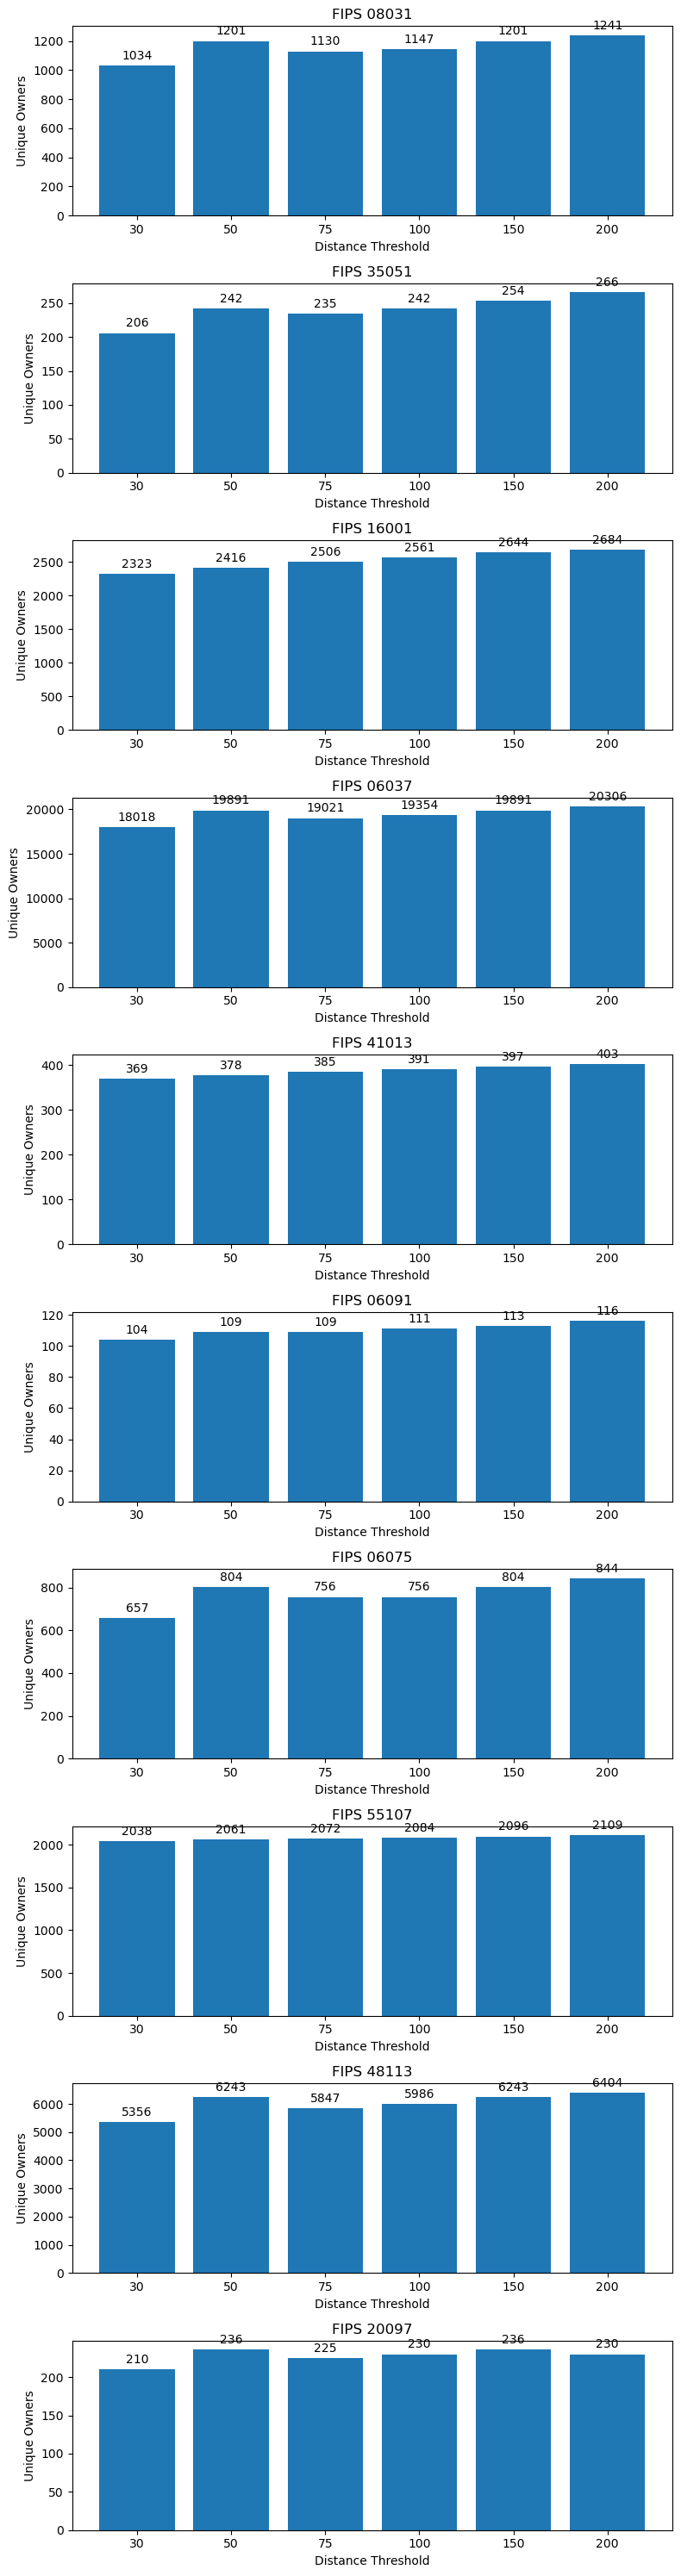

In [59]:
# Separate the index values and bar values
indexes = df.index.to_list()
bar_values = df.values

# Create one subplot for each row in the df
nrows = df.shape[0]
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(8, 3*nrows))

# In case there is only one row, ensure axes is iterable.
if nrows == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    # Create the bar plot for the current row
    bars = ax.bar(df.columns.to_list(), bar_values[i])
   
    ax.bar_label(bars, padding=3)
    
    # Set the title of the subplot to show the index value
    ax.set_title(f"FIPS {indexes[i]}")
    
    # Optionally, label axes
    ax.set_xlabel("Distance Threshold")
    ax.set_ylabel("Unique Owners")

plt.tight_layout()
plt.show()
